In [1]:
import networkx as nx
import matplotlib
import matplotlib.pylab as plt
import math

In [2]:
mouse_retina = nx.read_graphml("mouse_retina_1.graphml")
mouse_retina = mouse_retina.to_undirected()

In [3]:
mouse_retina = nx.Graph(mouse_retina) 

In [4]:
for component in list(nx.connected_components(mouse_retina)):
    if(len(component) < 50):
        for node in component:
            mouse_retina.remove_node(node)

F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


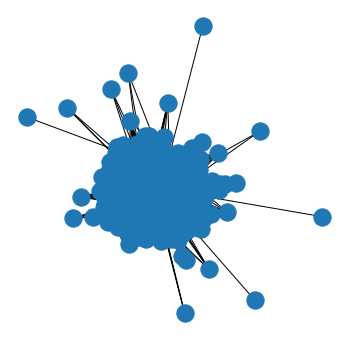

In [5]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(mouse_retina))

In [6]:
print("Number of nodes: " + str(len(mouse_retina.nodes())))
print("Number of edges: "  + str(len(mouse_retina.edges())))

Number of nodes: 1076
Number of edges: 90811


In [7]:
uc_network = nx.read_edgelist("UC_network.txt")

In [8]:
for component in list(nx.connected_components(uc_network)):
    if(len(component) < 50):
        for node in component:
            uc_network.remove_node(node)

count = 0
mapng = {}
for n in uc_network.nodes():
    mapng[n] = count
    count+=1
uc_network = nx.relabel_nodes(uc_network, mapng)

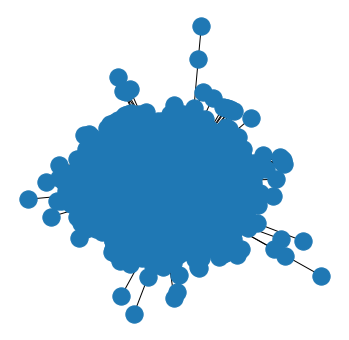

In [9]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(uc_network))

In [10]:
print("Number of nodes: " + str(len(uc_network.nodes())))
print("Number of edges: "  + str(len(uc_network.edges())))

Number of nodes: 1893
Number of edges: 15728


In [2]:
def Q(G, C):
    m = len(G.edges())
    outside = 1/(2*m)
    inside = 0
    for i in G.nodes():
        for j in G.nodes():
            Aij = 1 if G.has_edge(i, j) else 0
            k = G.degree(i) * G.degree(j)
            kronecker_delta = 1 if C[i] == C[j] else 0
            inside += (Aij - (k/2*m))*(kronecker_delta)
    return outside * inside 

In [3]:
# def delta_Q(v, n, C, G):
def delta_Q(v, C, G):
    sigma_in = 0 
    for edge in G.edges():
        if(C[v] == C[edge[0]] and C[v] == C[edge[1]]):
            sigma_in += 1
    ######################################
    k_in = 0
    for neigh in G.neighbors(v):
        if(C[v] == C[neigh]):
            k_in += 1
    ######################################
    sigma_tot = 0
    for edge in G.edges():
        if(C[edge[0]] == C[v] and C[v] != C[edge[1]]):
            sigma_tot += 1
        elif(C[edge[1]] == C[v] and C[v] != C[edge[0]]):
            sigma_tot += 1
    ######################################      
    m = len(G.edges)
    first_term = (((sigma_in + k_in)/(2*m)) - (((sigma_tot + G.degree(v))/(2*m))**2))
    second_term = (sigma_in/(2*m)) - ((sigma_tot/(2*m))**2) - ((G.degree(v)/(2*m))**2)
    return first_term - second_term

In [4]:
def MoveNodes(G):
    C = {}
    for idx, n in enumerate(G.nodes()):
        C[idx] = n
    nodes_moved = True
    while nodes_moved:
        nodes_moved = False
        for v in G.nodes():
            best_q = delta_Q(v, C, G)
            best_c = C[v]
            for neighbor in G.neighbors(v):
                C_temp = C
                C_temp[v] = C[neighbor]
                gain_q = delta_Q(v, C_temp, G)
                if best_q < gain_q and gain_q > 0:
                    best_q = gain_q
                    best_c = C[neighbor]
                    nodes_moved = True
            C[v] = best_c
    return C 
        

In [20]:
def louvain_algorithm(G):
    G_prime = G
    C = {}
    for idx, n in enumerate(G_prime.nodes()):
        C[n] = idx
    q = -math.inf
    while q < Q(G_prime, C):
        q = Q(G_prime, C)
        C = MoveNodes(G_prime)
        for k in C.keys():
            print(k,":",C[k])
        #G_prime = Aggregate(G_prime, C)
        for idx, n in enumerate(G_prime.nodes()):
            C[n] = idx
    return G_prime

In [34]:
Gg = nx.gnp_random_graph(25, 0.35)

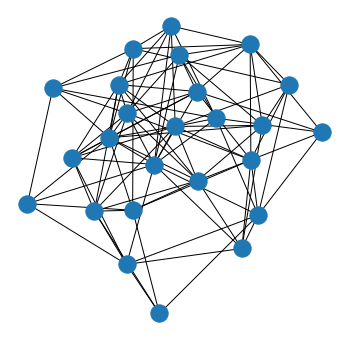

In [35]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(Gg))

In [36]:
louvain_algorithm(Gg)

0 : 2
1 : 2
2 : 2
3 : 17
4 : 2
5 : 17
6 : 17
7 : 2
8 : 20
9 : 21
10 : 17
11 : 2
12 : 2
13 : 21
14 : 14
15 : 2
16 : 16
17 : 17
18 : 14
19 : 19
20 : 20
21 : 20
22 : 17
23 : 2
24 : 21
